In [1]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
initializers = tf.keras.initializers

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data_generator import generator
from encoding.layers import IntegerBaseEncoder

2023-02-06 18:20:00.143814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
seed = 123
tf.random.set_seed(seed)
n_samples = 1000
n_features = 1
mean = 50
std = 10

for dist_name in ['normal', 'exponential']:
    gen = generator.DataGenerator(mean=mean, std=std, dist=dist_name, is_int=True)
    x, y = gen.generate(n_features=n_features, n_samples=n_samples)
    x = np.ravel(x)
    order = np.argsort(x).reshape(-1, 1)
    x, y = x[order], y[order]
    exec(f'x_{dist_name}=x\ny_{dist_name}=y')

In [3]:
standard = lambda x:(x - x.mean())/x.std()

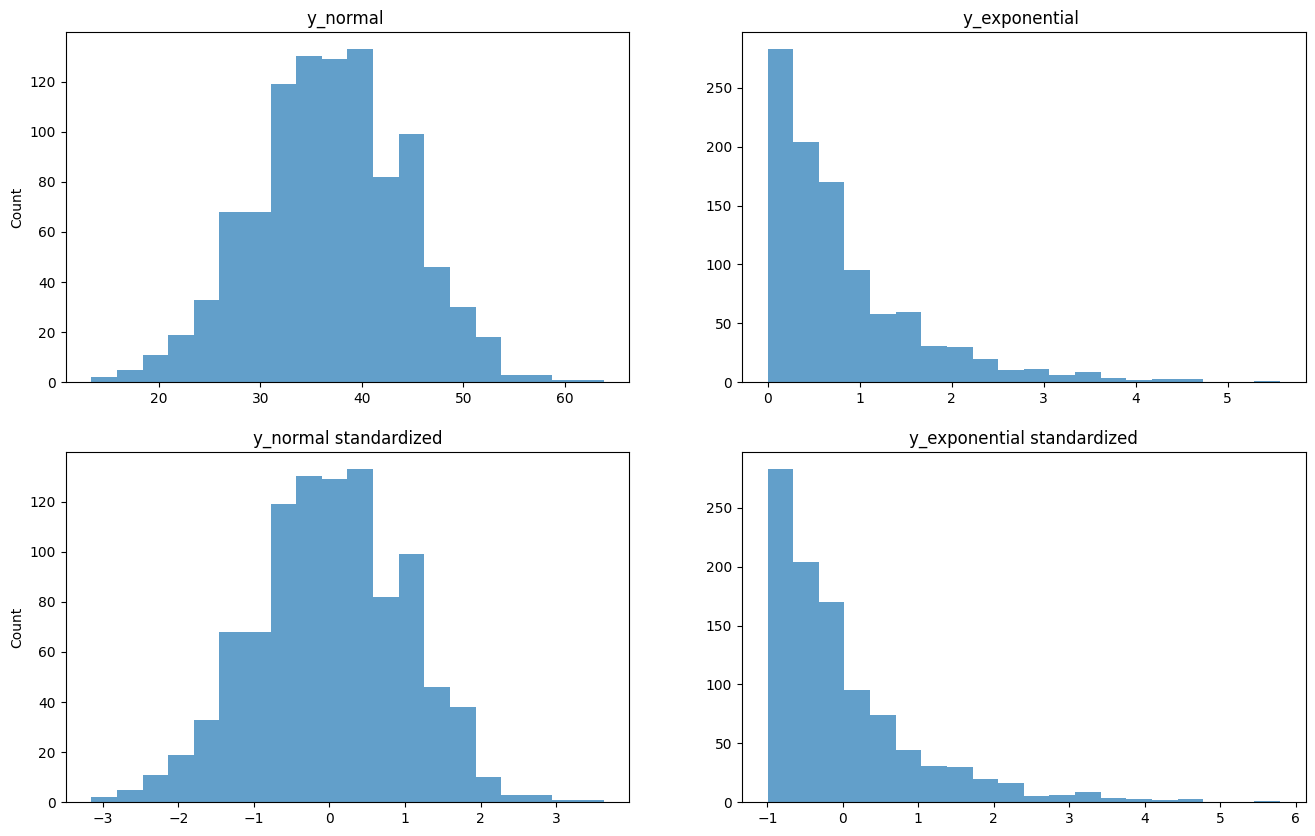

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate( ['y_normal', 'y_exponential']):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

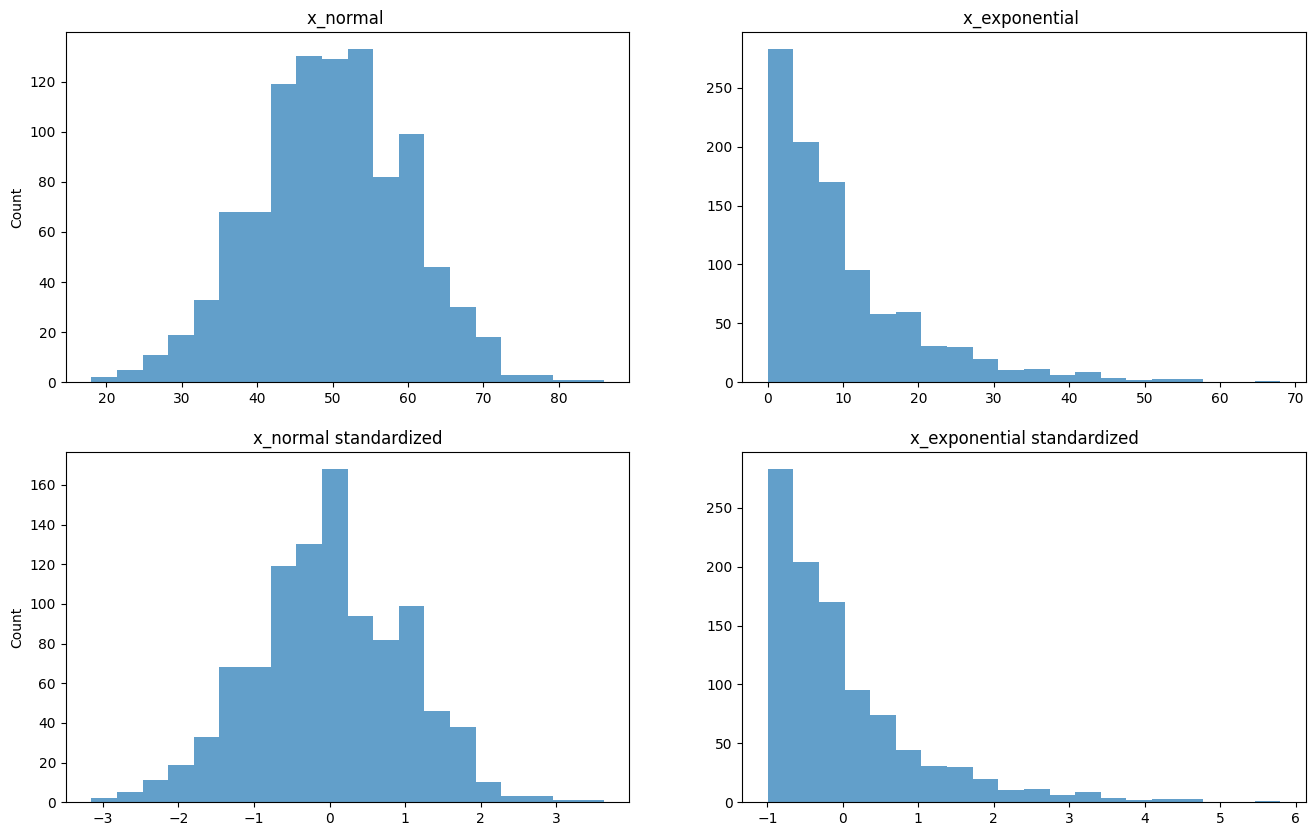

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate( ['x_normal', 'x_exponential']):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

In [ ]:
x_array = ['x_normal', 'x_exponential']
y_array = ['y_normal', 'y_exponential']

2023-02-06 18:20:03.287217: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-06 18:20:03.289513: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-06 18:20:03.352640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 18:20:03.352786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2023-02-06 18:20:03.352804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-06 18:20:03.355338: I tensorflow/stream_executor/platform/d

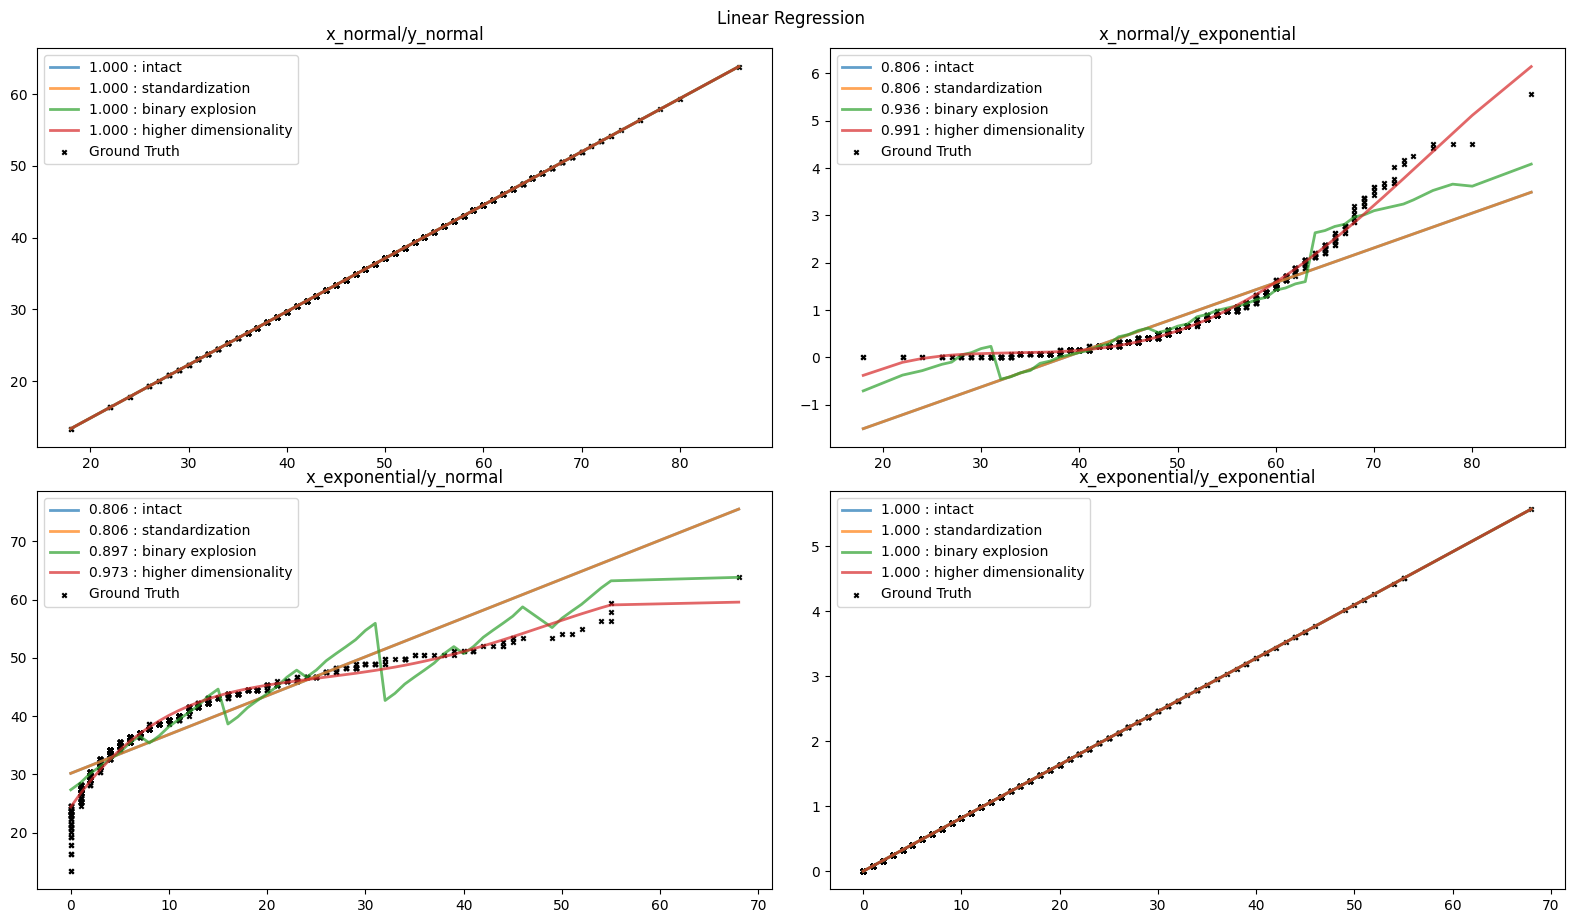

In [6]:
transform_layer = IntegerBaseEncoder()


fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()

tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'higher dimensionality': lambda x, n=5: np.power(x, np.arange(1, n))}
baseline = LinearRegression

for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            
            model = baseline()
            model.fit(transformed_x, cur_y)
                        
            y_hat = model.predict(transformed_x)
            score = model.score(transformed_x, cur_y)
            ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=2, label=f'{score:0.3f} : {name_transformation}')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('Linear Regression', y=1.02)
plt.show()

In [7]:
class _MLPBlock(keras.layers.Layer):
    def __init__(self, width, droprate=0, regularization=keras.regularizers.L1L2(0), **kwargs):
        super(_MLPBlock, self).__init__()
        self.dense = layers.Dense(width, 
                                  kernel_initializer=initializers.RandomNormal(seed=seed),
                                  kernel_regularizer=regularization, **kwargs)
#         self.activation = layers.ReLU()
#         self.drop = layers.Dropout(droprate)
#         self.bn = layers.BatchNormalization()
        
    def call(self, inputs, **kwargs):
        x = self.dense(inputs)
#         x = self.activation(x)
#         x = self.drop(x)
#         x = self.bn(x)
        return x

# implement policy network
class MLP(keras.Model):
    def __init__(self, input_dim, output_dim, hidden_dim=64, depth=1, **kwargs):
        super().__init__()
        self.depth = depth
        self.hidden_0 = _MLPBlock(hidden_dim, input_shape=(input_dim,), **kwargs)

        for i in range(1, depth):
            setattr(self, f'hidden_{i}', _MLPBlock(hidden_dim))
        self.out = _MLPBlock(output_dim)

    
    def call(self, inputs):
        x = inputs
        for i in range(self.depth):
            x = getattr(self, f'hidden_{i}')(x)
        x = self.out(x)
        return x

intact 0.23501134029165552
standardization 0.0001522030607987431
binary explosion 0.0001866784036867332
intact 0.023047054628895218
standardization 0.002102871730006783
binary explosion 0.0016719666404872765
intact 0.7010284819411243
standardization 0.7373299262573062
binary explosion 0.6706593862019739
intact 7.571982453835518e-07
standardization 6.757130077526298e-07
binary explosion 4.882643507362497e-07


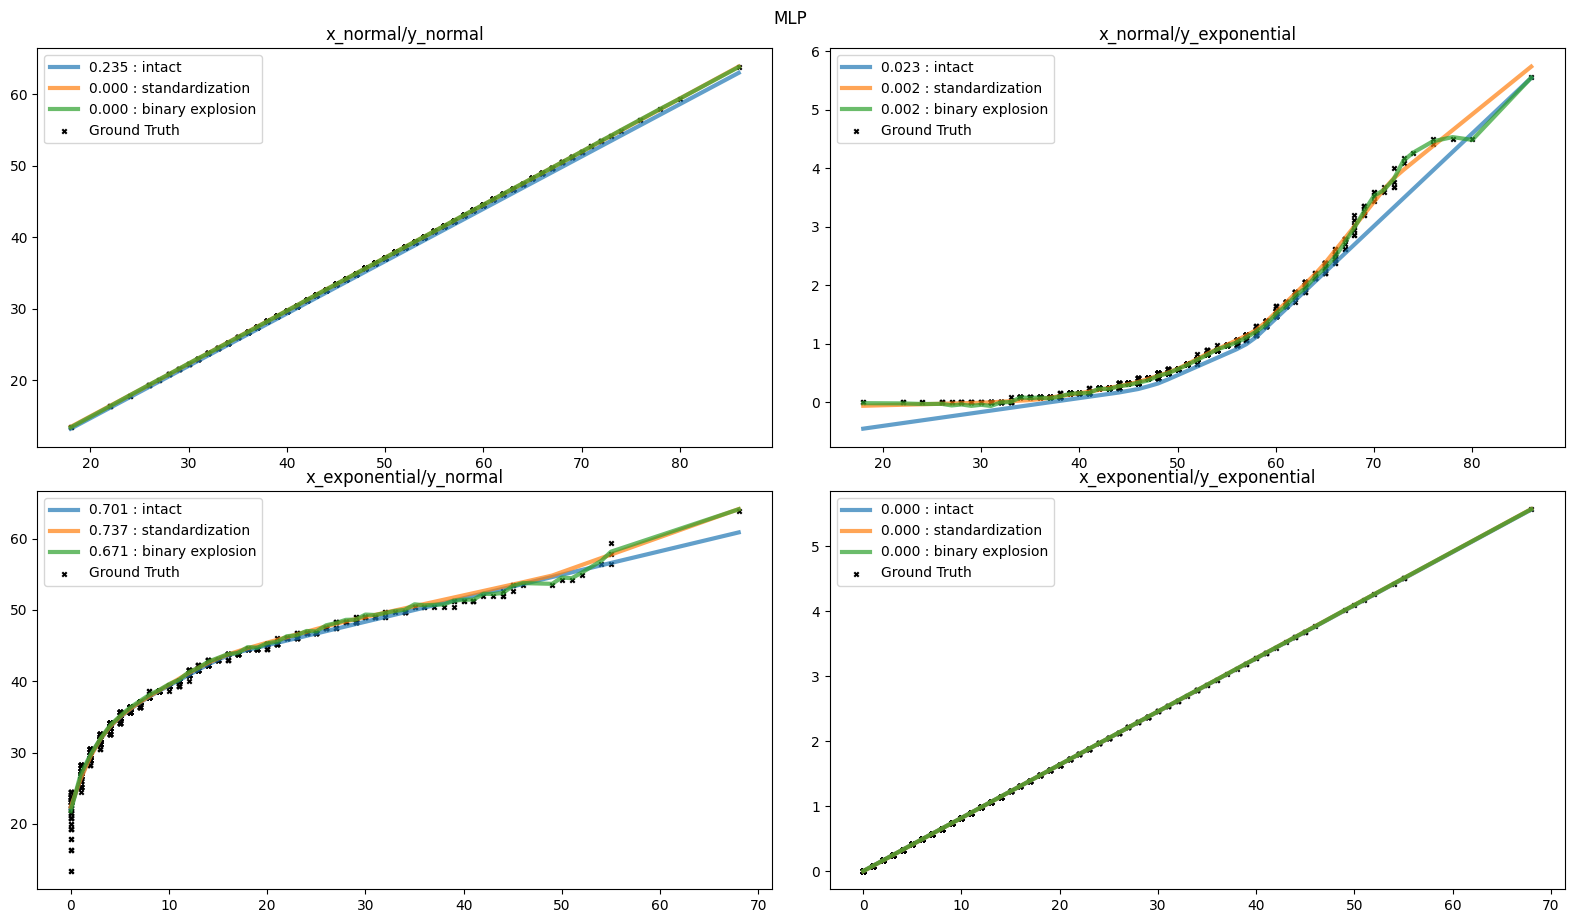

In [9]:
fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()
transform_layer = IntegerBaseEncoder()
activation = activation=keras.activations.relu
tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1)}


for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)
        

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            try:
                model = MLP(transformed_x.shape[1], 1, 1024, depth=2, activation=activation)
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
                model.fit(transformed_x, cur_y, epochs=300, verbose=0)
                y_hat = model.predict(transformed_x)
                score = mse(y_hat, cur_y)
                print(name_transformation, score)
                ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
            except:
                print(name_transformation, 'NANS')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('MLP', y=1.02)
plt.show()